In [ ]:
import pandas as pd
import os
import numpy as np
import seaborn as sns 
import plotly.express as px
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.cm as cm

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")

from src.functions.embryo_df_performance_metrics import *
from src.functions.spline_morph_spline_metrics   import *

results_dir = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250310"
save_dir = os.path.join(results_dir, "data")

model_index = 74
df_orig = pd.read_csv("/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter030/SeqVAE_training_2024-11-11_15-45-40/figures/embryo_stats_df.csv")

z_mu_columns = [col for col in df_orig.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

Import morphseq key to sci-data

In [4]:
# Read the morphseq metadata file into a dataframe
morphseq_seq_key_path = "/net/trapnell/vol1/home/mdcolon/proj/morphseq/results/mcolon/20250310/data/morphseq_metadata.csv"
morphseq_metadata = pd.read_csv(morphseq_seq_key_path)

# Display the first few rows
# print(morphseq_metadata.head())


In [7]:
# Specify the minimum number of snip_ids per embryo_id
pert_comparisons = ["wt","lmx1b", "inj-ctrl"]

df    = df_orig[df_orig["phenotype"].isin(pert_comparisons)]
df   = apply_pca_on_pert_comparisons(df  ,z_mu_biological_columns )

df["phenotype"].unique()

No perturbations specified. Using all available phenotypes: ['wt', 'lmx1b', 'inj-ctrl']

PCA Explained Variance:
----------------------------
Total Explained Variance by 3 components: 86.00%

Principal Component Explained Variance Ratio
              PCA_1                   41.85%
              PCA_2                   33.45%
              PCA_3                   10.70%
----------------------------



array(['wt', 'lmx1b', 'inj-ctrl'], dtype=object)

In [9]:
pert_splines, df_augmented, segment_info_df = build_splines_and_segments(
    df=df,
    comparisons=pert_comparisons,
    save_dir=save_dir,
    model_index=model_index,
    LocalPrincipalCurveClass=LocalPrincipalCurve,
    bandwidth=0.5,
    max_iter=250,
    tol=1e-3,
    angle_penalty_exp=2,
    early_stage_offset=1.0,
    late_stage_offset=3.0,
    k=50
)

Using specified comparisons for spline building: ['wt', 'lmx1b', 'inj-ctrl']
Building spline data for each phenotype...


Creating splines for each phenotype:   0%|                                                                                                                                                                                                      | 0/3 [00:00<?, ?it/s]

Starting point not in dataset. Using closest point: [1.3326502  1.49841303 2.25648313]


Creating splines for each phenotype:  33%|███████████████████████████████████████████████████████████████▎                                                                                                                              | 1/3 [00:47<01:35, 47.80s/it]

Starting point not in dataset. Using closest point: [1.37973703 1.87687887 1.04008643]


Creating splines for each phenotype:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2/3 [01:03<00:28, 28.64s/it]

Starting point not in dataset. Using closest point: [1.29634927 1.85966943 1.31861981]


Creating splines for each phenotype: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:05<00:00, 21.96s/it]


Spline DataFrame 'pert_splines' saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250310/pert_splines_74_unique.csv
Assigning segments and building segment_info_df...


Processing phenotypes: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [07:56<00:00, 158.93s/it]


In [ ]:
wt_splines_n_planes = segment_info_df[segment_info_df["phenotype"] == "wt"]

# A) Points from "wt" itself
# wt_pert_df = df_augmented[df_augmented["phenotype"] == "wt"]
df_points_proj = project_points_onto_reference_spline(
    df_augmented,
    wt_splines_n_planes
)

df_augmented_projec_wt = pd.merge(
    df_augmented, 
    df_points_proj.drop(columns=[col for col in df_points_proj.columns if col in df_augmented.columns and col != "snip_id"]),
    on="snip_id"
)

In [14]:

fig = plot_3d_spline_and_projections(
    projection_dfs =[df_augmented_projec_wt],
    segment_info_df=wt_splines_n_planes,
    pert_splines=pert_splines,  # or None if you don't have/need them
    save_dir=save_dir,
    filename="3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstrap.html",
    k=None,
    title="3D Spline + Projection Visualization lmx1b and wt used for bootstrap",
    plane_opacity=0.2,
    axis_length=0.5,
    show_legend=True
)

3D visualization saved to: /net/trapnell/vol1/home/mdcolon/proj/morphseq/results/20250310/data/3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstrap.html


In [15]:
fig.write_html(os.path.join(save_dir, "3d_vis_spline_n_planes_wt_lmx1b_test_used for bootstrap.html"))

In [ ]:
df_augmented_projec_wt

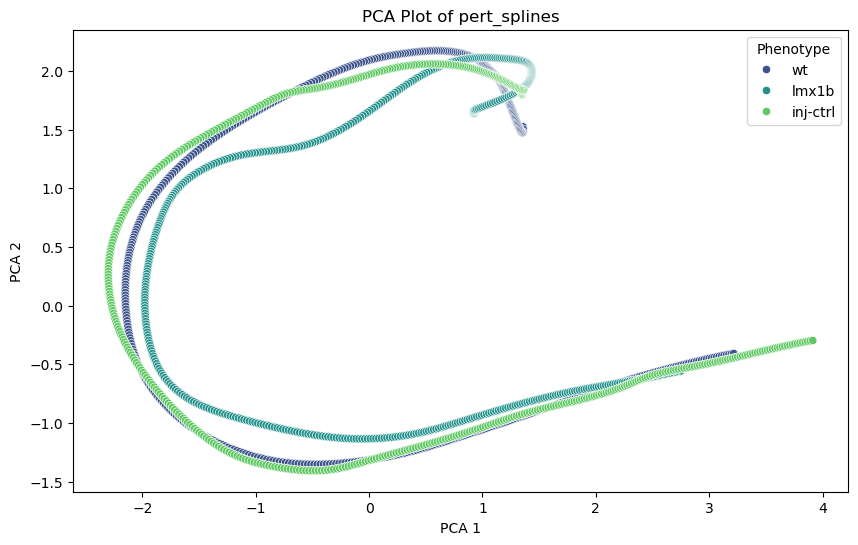

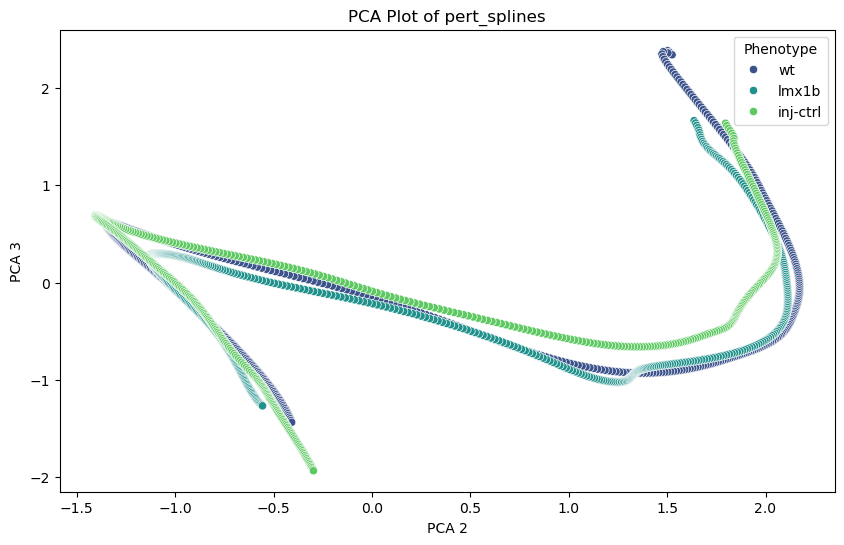

In [24]:

# Plot PCA_1 vs PCA_2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pert_splines, x='PCA_1', y='PCA_2', hue='phenotype', palette='viridis')
plt.title('PCA Plot of pert_splines')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Phenotype')
plt.show()

# Plot PCA_1 vs PCA_2
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pert_splines, x='PCA_2', y='PCA_3', hue='phenotype', palette='viridis')
plt.title('PCA Plot of pert_splines')
plt.xlabel('PCA 2')
plt.ylabel('PCA 3')
plt.legend(title='Phenotype')
plt.show()

## now that we have data to determine phenotypic severity lets sake a loook

In [59]:
morphseq_metadata = morphseq_metadata.rename(columns={"sample": "embryo_ID"})

morphseq_metadata = morphseq_metadata[morphseq_metadata["qc_flag"]==0]

morphseq_metadata

,image_well,genotype,hash_well,temperature,hash_plate_num,stage_hpf,image_notes,qc_flag,experiment_date,sci_expt,...,timepoint,drug_addition,stage,dose,temp,cells_per_embryo,perturbation,target,strain,has_sci_data
0,A01,lmx1b,A01,28.5,1,48.0,NaN,0,20231207,LMX1B,...,48.0,False,48,False,28.0,NaN,lmx1ba;lmx1bb,lmx1ba;lmx1bb,AB,1
1,A02,lmx1b,A02,28.5,1,48.0,NaN,0,20231207,LMX1B,...,48.0,False,48,False,28.0,NaN,lmx1ba;lmx1bb,lmx1ba;lmx1bb,AB,1
2,A03,ctrl-inj,A03,28.5,1,48.0,NaN,0,20231207,LMX1B,...,48.0,False,48,False,28.0,NaN,ctrl-inj,Control,AB,1
3,A04,tbxta,A04,28.5,1,24.0,NaN,0,20231207,LMX1B,...,24.0,False,24,False,28.0,NaN,tbxta-mut,tbxta,unknown,1
4,B01,lmx1b,B01,28.5,1,48.0,NaN,0,20231207,LMX1B,...,48.0,False,48,False,28.0,NaN,lmx1ba;lmx1bb,lmx1ba;lmx1bb,AB,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
797,H06,ab,H07,28.5,5,24.0,NaN,0,20250219_24hpf,CHEM_TBD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
798,H07,ab,H01,28.5,6,24.0,NaN,0,20250219_24hpf,CHEM_TBD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
799,H08,ab,H02,28.5,6,24.0,NaN,0,20250219_24hpf,CHEM_TBD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
800,H09,ab,H04,28.5,6,24.0,NaN,0,20250219_24hpf,CHEM_TBD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [62]:
# Subset the DataFrame
morphseq_metadata_lmx1b_expr = morphseq_metadata[morphseq_metadata["perturbation"].isin(["lmx1ba;lmx1bb", "ctrl-inj", "reference"])]
morphseq_metadata_lmx1b_expr_snip_ids = morphseq_metadata_lmx1b_expr["snip_id"]
morphseq_metadata_lmx1b_expr_phenotype = morphseq_metadata_lmx1b_expr["phenotype"]

In [63]:
embryo_df_augmented_lmx1b_expr = df_augmented_projec_wt[df_augmented_projec_wt["snip_id"].isin(morphseq_metadata_lmx1b_expr_snip_ids)]

In [64]:
print(embryo_df_augmented_lmx1b_expr[embryo_df_augmented_lmx1b_expr["snip_id"]== "20231207_E02_e00_t0000"]["hypotenuse"].values[0])
print(embryo_df_augmented_lmx1b_expr[embryo_df_augmented_lmx1b_expr["snip_id"]== "20231207_D01_e00_t0000"]["hypotenuse"].values[0])


1.269593093204069


IndexError: index 0 is out of bounds for axis 0 with size 0

# checking that the distance fro psline isnt skewed or anything 

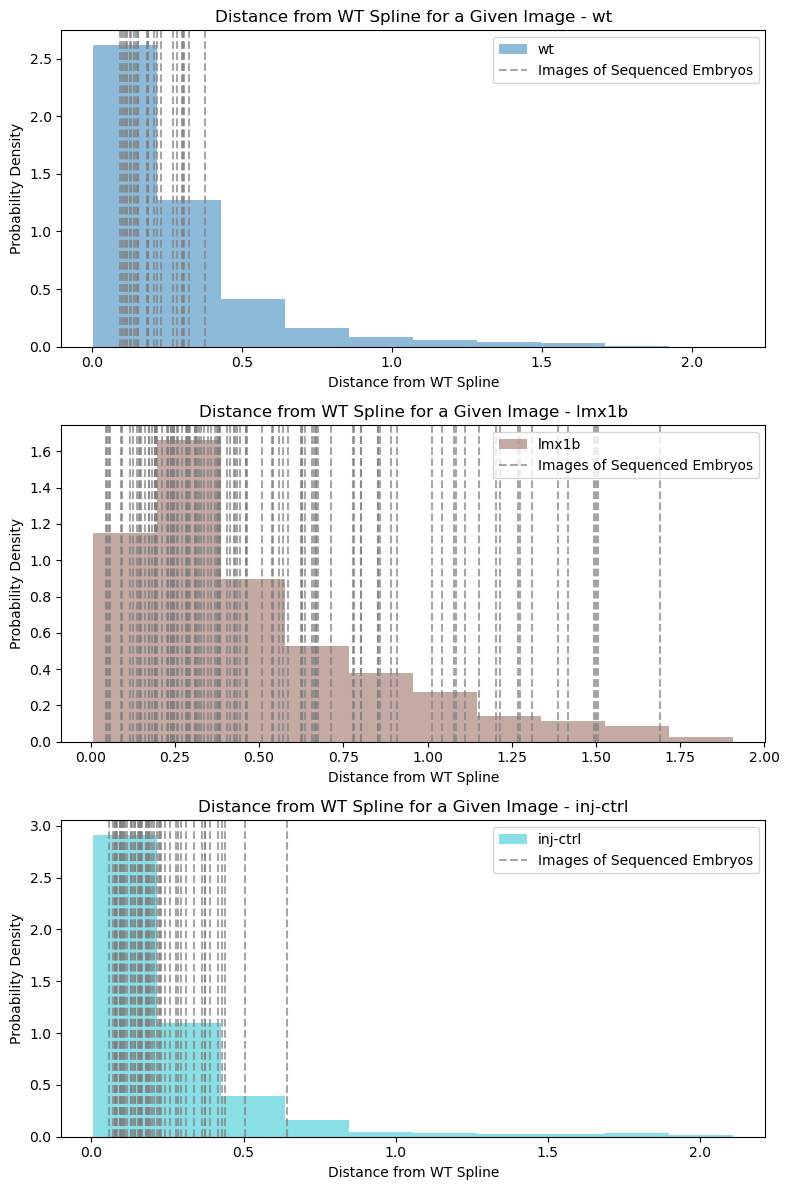

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Gather snip IDs from morphseq_metadata_lmx1b_expr
special_snip_ids = morphseq_metadata_lmx1b_expr["snip_id"].unique()

# 2. Get unique phenotypes
unique_phenotypes = df_augmented_projec_wt["phenotype"].unique()

# 3. Prepare a color map so each phenotype has a distinct color
#    (tab10 has 10 distinct colors; adjust if you have more than 10 phenotypes)
cmap = plt.cm.get_cmap('tab10')
colors = cmap(np.linspace(0, 1, len(unique_phenotypes)))

# 4. Create subplots (one column, multiple rows)
fig, axes = plt.subplots(
    nrows=len(unique_phenotypes),
    ncols=1,
    figsize=(8, 4 * len(unique_phenotypes))
)

# If there's only one phenotype, axes won't be iterable; handle that gracefully
if len(unique_phenotypes) == 1:
    axes = [axes]  # Make it a list so we can zip properly

# 5. Plot each phenotype in its own subplot
for i, (ax, phenotype) in enumerate(zip(axes, unique_phenotypes)):
    # Subset rows for this phenotype
    subset = df_augmented_projec_wt[df_augmented_projec_wt["phenotype"] == phenotype]
    
    # Plot the histogram with a unique color
    ax.hist(
        subset["hypotenuse"],
        bins=10,
        alpha=0.5,
        density=True,
        label=phenotype,
        color=colors[i]
    )
    
    # Filter the subset for snip IDs in special_snip_ids
    subset_special = subset[subset["snip_id"].isin(special_snip_ids)]
    
    # If there are any “special” snips in this phenotype, add gray lines.
    # Add a dummy line for the legend so it appears as "Images of Sequenced Embryos."
    if not subset_special.empty:
        # Add one legend handle
        ax.plot([], [], color="gray", linestyle="--", alpha=0.7, 
                label="Images of Sequenced Embryos")
        
        # Draw a gray vertical line for each matching snip
        for val in subset_special["hypotenuse"]:
            ax.axvline(x=val, color="gray", linestyle="--", alpha=0.7)
    
    ax.set_xlabel("Distance from WT Spline")
    ax.set_ylabel("Probability Density")
    ax.set_title(f"Distance from WT Spline for a Given Image - {phenotype}")
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
df_augmented_projec_wt.to_csv(os.path.join(save_dir, "embryo_df_augmented_projec_wt.csv"), index=False)
embryo_df_augmented_lmx1b_expr[["snip_id","embryo_id" ,"hypotenuse"]].to_csv(os.path.join(save_dir, "mseq_lmx1b_snipid_to_distfromspline.csv"), index=False
